In [1]:
%cd ..

d:\github\ripple_heterogeneity\python


In [2]:
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt
import matplotlib

import hdf5storage
import h5py
import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

import math
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

import multiprocessing
from joblib import Parallel, delayed
        

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = 'G:/My Drive/post_doc/ripple_diversity/project_log'

In [4]:
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

In [209]:
import warnings
warnings.filterwarnings("ignore")

def main(st_rip,ripple_epochs,cell_metrics,ripples):
    n_deep = np.zeros([3,ripple_epochs.n_intervals])
    n_sup = np.zeros_like(n_deep)
    n_deep_whole_rip = np.zeros([1,ripple_epochs.n_intervals])
    n_sup_whole_rip = np.zeros_like(n_deep_whole_rip)

    for rip_i in range(ripple_epochs.n_intervals):

        active = [unit.shape[0]>0 for unit in st_rip[rip_i].data]
        n_deep_whole_rip[0,rip_i] = sum(cell_metrics.deepSuperficial[active] == "Deep")
        n_sup_whole_rip[0,rip_i] = sum(cell_metrics.deepSuperficial[active] == "Superficial")

        ts = np.linspace(ripple_epochs[rip_i].starts,ripple_epochs[rip_i].stops,4)
        within_ripple_epochs = nel.EpochArray(np.array([[ts[0],ts[1]],[ts[1],ts[2]],[ts[2],ts[3]]]))

        for rip_inter in range(3):
            active = [unit.shape[0]>0 for unit in st_rip[rip_i][within_ripple_epochs][rip_inter].data]
            n_deep[rip_inter,rip_i] = sum(cell_metrics.deepSuperficial[active] == "Deep")
            n_sup[rip_inter,rip_i] = sum(cell_metrics.deepSuperficial[active] == "Superficial")

    # normalize by n units
    n_deep = n_deep/sum(cell_metrics.deepSuperficial == "Deep")
    n_sup = n_sup/sum(cell_metrics.deepSuperficial == "Superficial")
    n_deep_whole_rip = n_deep_whole_rip/sum(cell_metrics.deepSuperficial == "Deep")
    n_sup_whole_rip = n_sup_whole_rip/sum(cell_metrics.deepSuperficial == "Superficial")

    np.median(n_sup,axis=1)
    np.median(n_deep,axis=1)
    
    ripples['deep whole'] = n_deep_whole_rip[0,:]
    ripples['sup whole'] = n_sup_whole_rip[0,:]
    ripples['deep start'] = n_deep[0,:]
    ripples['deep middle'] = n_deep[1,:]
    ripples['deep end'] = n_deep[1,:]
    ripples['sup start'] = n_sup[0,:]
    ripples['sup middle'] = n_sup[1,:]
    ripples['sup end'] = n_sup[1,:]

    return ripples
df = pd.read_csv(r'D:\projects\ripple_heterogeneity\sessions.csv')
save_path = r'D:\projects\ripple_heterogeneity\ripple_segments'

for basepath in tqdm(df.basepath):

    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.csv')
    if os.path.exists(save_file):
        continue

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")))

    cell_metrics = cell_metrics[restrict_idx]

    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
    st_rip = st[ripple_epochs]

    ripples_results = main(st_rip,ripple_epochs,cell_metrics,ripples)

    ripples_results.to_csv(save_file)


  0%|          | 0/264 [00:00<?, ?it/s]

In [207]:
save_path = r'D:\projects\ripple_heterogeneity\ripple_segments'
# os.path.join(save_path,os.path.basename(basepath))+'.csv'

save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.csv')
save_file

'D:\\projects\\ripple_heterogeneity\\ripple_segments\\A__Data_AYA9_day20.pkl'

   name  startTime  stopTime
0  task        0.0    6022.4
1  post     6022.4   15169.1


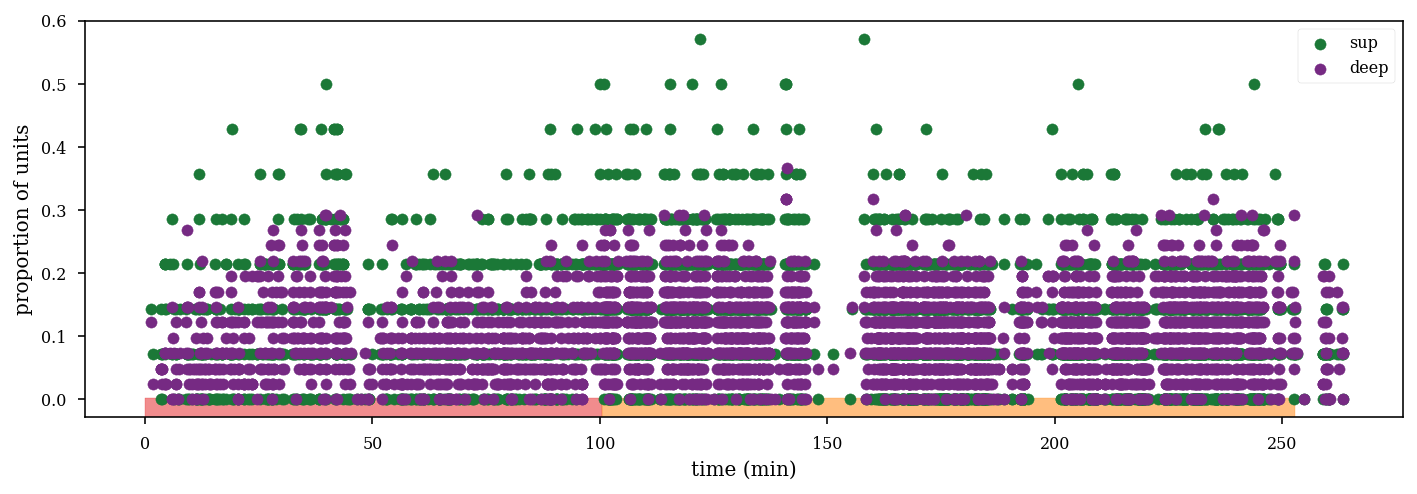

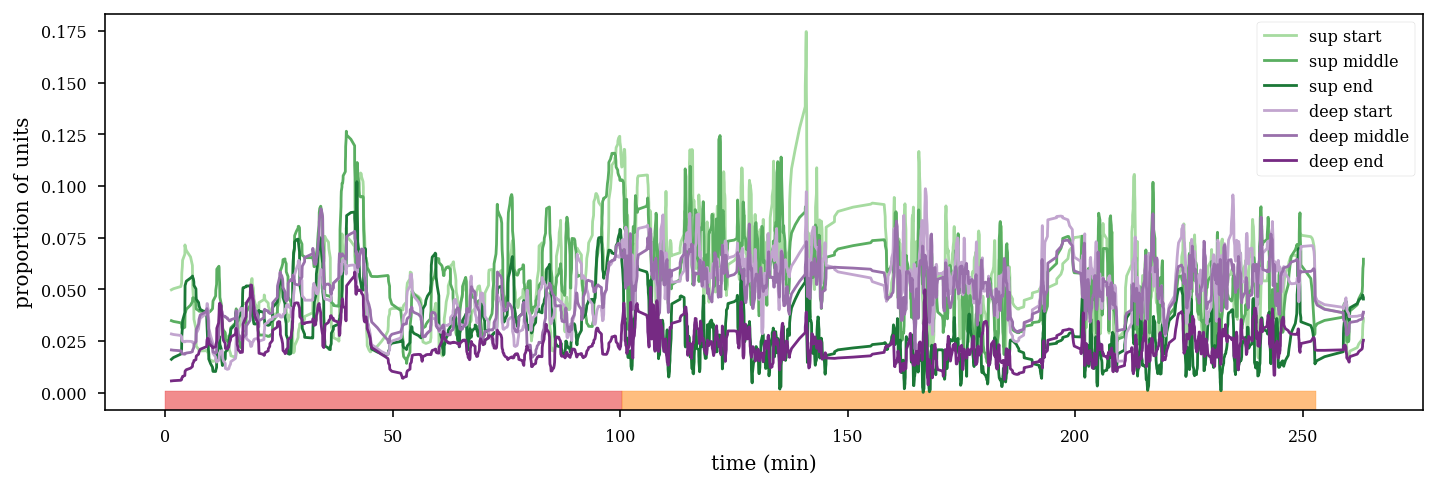

In [163]:
# plt.figure(figsize=(20,4))
# plt.imshow(n_deep,aspect="auto",interpolation="nearest",vmax=.3,vmin=0)
# plt.figure(figsize=(20,4))
# plt.imshow(n_sup,aspect="auto",interpolation="nearest",vmax=.3,vmin=0)
cmap = matplotlib.cm.get_cmap('Set1',data["epochs"].shape[0]+1)

plt.figure(figsize=functions.set_size('thesis', fraction=2, subplots=(1, 2)), edgecolor='k')
plt.scatter(ripples.peaks/60,n_sup_whole_rip[0,:],color='#1b7837',label="sup")
plt.scatter(ripples.peaks/60,n_deep_whole_rip[0,:],color='#762a83',label="deep")
plt.xlabel('time (min)')
plt.ylabel('proportion of units')

for i,epochs in enumerate(data["epochs"].itertuples()):
    plt.axvspan(epochs.startTime/60, epochs.stopTime/60,
                ymin=-.1,ymax=.05, alpha=0.5, color=cmap(i), zorder=-1000)
plt.legend()

plt.figure(figsize=functions.set_size('thesis', fraction=2, subplots=(1, 2)), edgecolor='k')

plt.plot(ripples.peaks/60,gaussian_filter1d(n_sup[0,:], 5),color='#a6dba0',label="sup start")
plt.plot(ripples.peaks/60,gaussian_filter1d(n_sup[1,:], 5),color='#5aae61',label="sup middle")
plt.plot(ripples.peaks/60,gaussian_filter1d(n_sup[2,:], 5),color='#1b7837',label="sup end")

plt.plot(ripples.peaks/60,gaussian_filter1d(n_deep[0,:], 5),color='#c2a5cf',label="deep start")
plt.plot(ripples.peaks/60,gaussian_filter1d(n_deep[1,:], 5),color='#9970ab',label="deep middle")
plt.plot(ripples.peaks/60,gaussian_filter1d(n_deep[2,:], 5),color='#762a83',label="deep end")

for i,epochs in enumerate(data["epochs"].itertuples()):
    plt.axvspan(epochs.startTime/60, epochs.stopTime/60,
                ymin=-.1,ymax=.05, alpha=0.5, color=cmap(i), zorder=-1000)
    # plt.axvline(epochs.startTime/60,color="k",zorder=-1000)
plt.xlabel('time (min)')
plt.ylabel('proportion of units')

plt.legend()
fig_save_path = 'G:/My Drive/post_doc/ripple_diversity/project_log'
print(data["epochs"])
plt.savefig(os.path.join(fig_save_path,'ripple_segment_participation_example.pdf'),dpi=300,bbox_inches='tight')
# plt.savefig(os.path.join(fig_save_path,'ripple_segment_participation_example.png'),dpi=300,bbox_inches='tight')


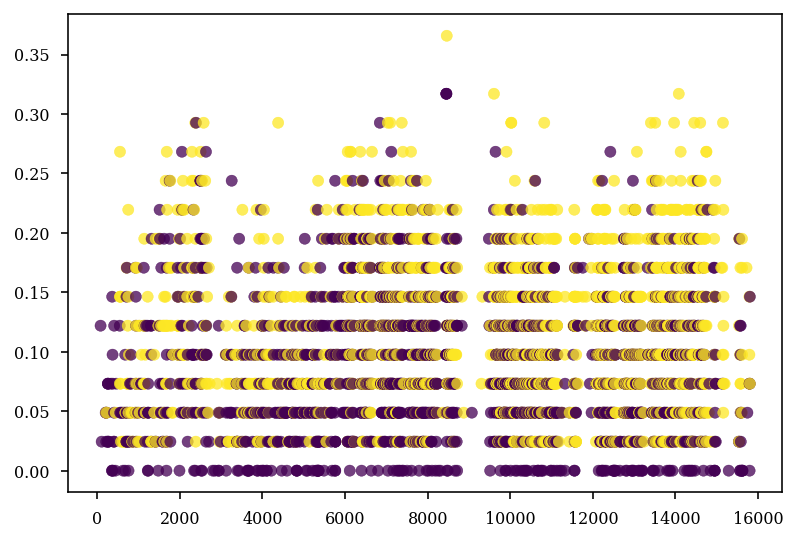

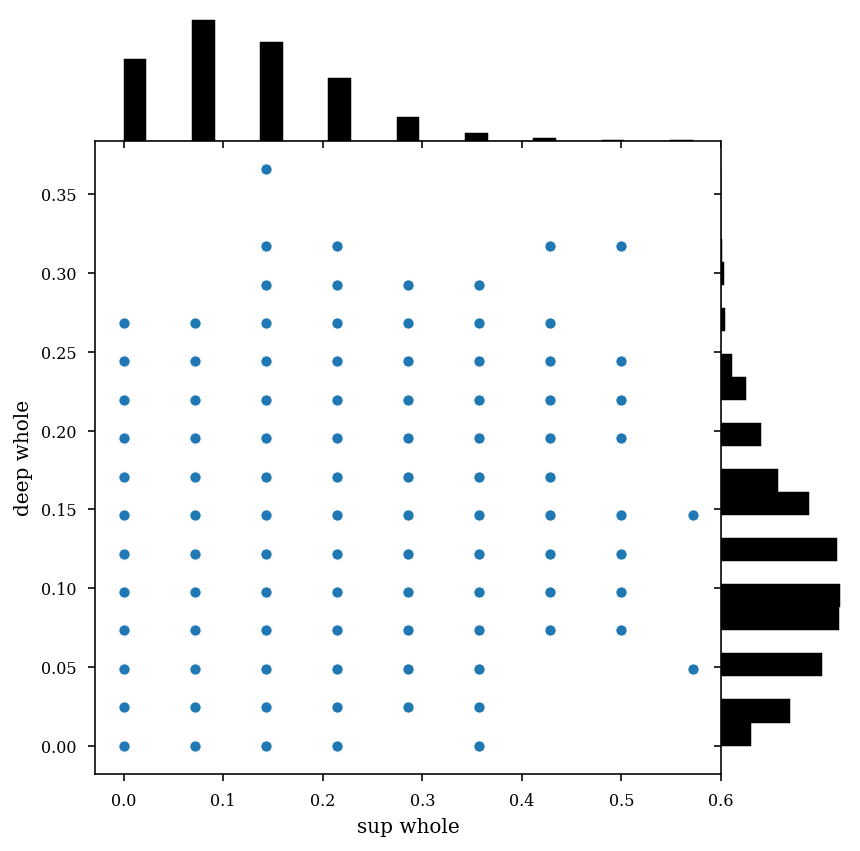

In [145]:
plt.scatter(ripples.peaks,n_deep_whole_rip[0,:],c=deep_dom,alpha=.75)
plt.show()

# plt.scatter(ripples.peaks,n_sup_whole_rip[0,:],c=ripples.duration,alpha=.75)
# plt.show()

g = sns.JointGrid(data=session_df, x="sup whole", y="deep whole", space=0)
g.plot_joint(sns.scatterplot,cmap="rocket")
g.plot_marginals(sns.histplot, color="k", alpha=1, bins=25)

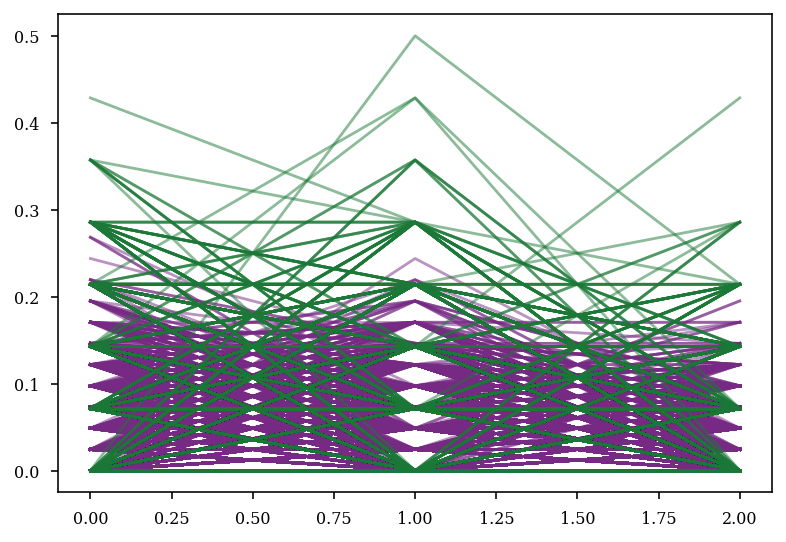

In [162]:
plt.plot(n_deep,color='#762a83',alpha=.5)
plt.plot(n_sup,color='#1b7837',alpha=.5)

plt.show()

In [165]:
sum(cell_metrics.deepSuperficial == "Superficial") / cell_metrics.shape[0]
sum(cell_metrics.deepSuperficial == "Deep") / cell_metrics.shape[0]


0.7454545454545455

In [169]:
n_deep_whole_rip[0,:]

array([0.12195122, 0.02439024, 0.04878049, ..., 0.07317073, 0.07317073,
       0.14634146])

In [182]:
print(n_deep_whole_rip[0,:])
n_deep_whole_rip[0,:] / sum(cell_metrics.deepSuperficial == "Deep")

[0.12195122 0.02439024 0.04878049 ... 0.07317073 0.07317073 0.14634146]


array([0.00297442, 0.00059488, 0.00118977, ..., 0.00178465, 0.00178465,
       0.0035693 ])

In [181]:
print(n_sup_whole_rip[0,:])
n_sup_whole_rip[0,:] / sum(cell_metrics.deepSuperficial == "Superficial")

[0.14285714 0.07142857 0.14285714 ... 0.14285714 0.07142857 0.21428571]


array([0.01020408, 0.00510204, 0.01020408, ..., 0.01020408, 0.00510204,
       0.01530612])

<AxesSubplot:>

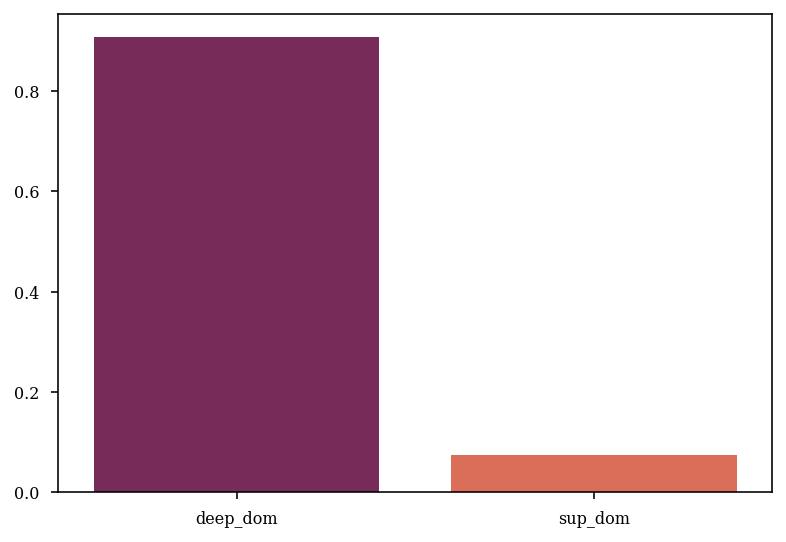

In [190]:
deep_dom = n_deep_whole_rip[0,:] * (sum(cell_metrics.deepSuperficial == "Deep")/cell_metrics.shape[0]) > n_sup_whole_rip[0,:] * (sum(cell_metrics.deepSuperficial == "Superficial")/cell_metrics.shape[0])
sup_dom = n_deep_whole_rip[0,:] * (sum(cell_metrics.deepSuperficial == "Deep")/cell_metrics.shape[0]) < n_sup_whole_rip[0,:] * (sum(cell_metrics.deepSuperficial == "Superficial")/cell_metrics.shape[0])

sns.barplot(x=['deep_dom','sup_dom'], y=[deep_dom.sum()/len(deep_dom),sup_dom.sum()/len(deep_dom)], palette="rocket")

In [156]:
deep_dom = n_deep_whole_rip[0,:] > n_sup_whole_rip[0,:]
sup_dom = n_deep_whole_rip[0,:] < n_sup_whole_rip[0,:]

equal_dom = n_deep_whole_rip[0,:] == n_sup_whole_rip[0,:]

np.where(sup_dom)[0][0:10]
# np.where(deep_dom)[0]


array([ 0,  1,  2,  3,  5,  6,  8,  9, 10, 11], dtype=int64)

In [140]:
session_df = pd.DataFrame()
session_df['duration'] = ripples.duration
session_df['peaks'] = ripples.peaks

session_df['deep whole'] = n_deep_whole_rip[0,:]
session_df['sup whole'] = n_sup_whole_rip[0,:]

session_df['deep start'] = n_deep[0,:]
session_df['deep middle'] = n_deep[1,:]
session_df['deep end'] = n_deep[1,:]
session_df['sup start'] = n_sup[0,:]
session_df['sup middle'] = n_sup[1,:]
session_df['sup end'] = n_sup[1,:]

# sns.histplot(data=session_df,stat="density",cumulative=True,element="step", fill=False)
# sns.histplot(data=session_df, element="step", fill=False,stat="density",common_bins=False,kde=True)


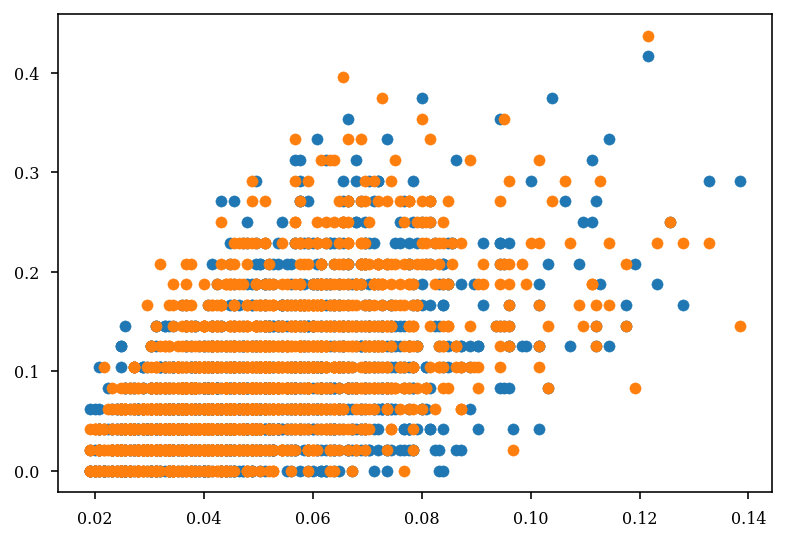

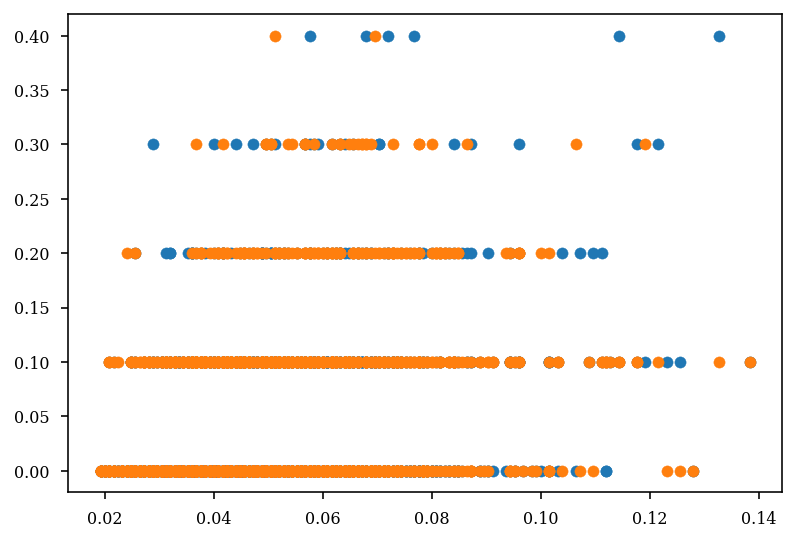

In [90]:
plt.scatter(ripples.duration,session_df['deep start'])
# plt.scatter(ripples.duration,session_df['deep middle'])
# plt.scatter(ripples.duration,session_df['deep end'])

plt.figure()
plt.scatter(ripples.duration,session_df['sup start'])
plt.scatter(ripples.duration,session_df['sup middle'])
# plt.scatter(ripples.duration,session_df['sup end'])

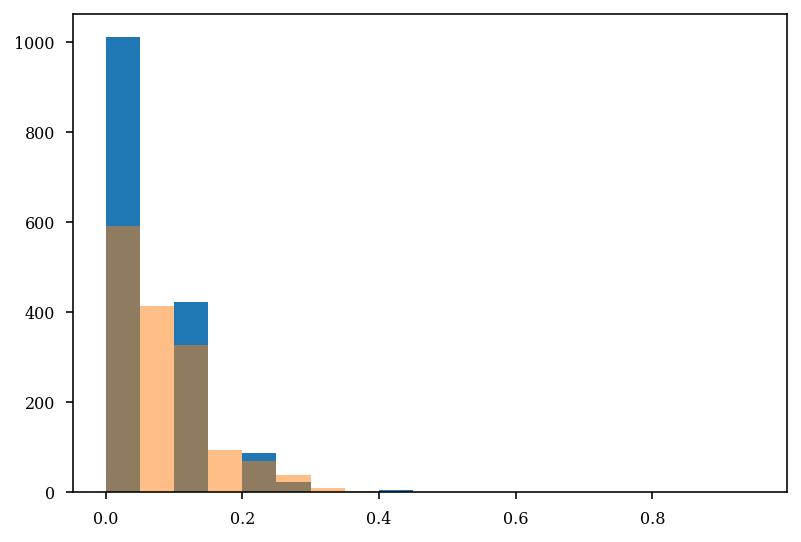

In [55]:
# plt.scatter(n_deep[2,:],n_sup[2,:])
bins = np.arange(0,1,.05)
plt.hist(n_sup[0,:],bins=bins)
plt.hist(n_deep[0,:],bins=bins,alpha=.5)

plt.show()

In [46]:
ts_epoch = []
for rip_i in range(ripple_epochs.n_intervals):
    ts = np.linspace(ripple_epochs[rip_i].starts,ripple_epochs[rip_i].stops,4)
    ts_epoch.append([ts[0],ts[1]])
    ts_epoch.append([ts[1],ts[2]])
    ts_epoch.append([ts[2],ts[3]])

ripple_seg_epochs = nel.EpochArray(np.hstack(ts_epoch).T)
st_rip_seg = st[ripple_seg_epochs]

# n_deep = []
# n_sup = []

def main_loop(rip_i,st_rip_seg,cell_metrics):
    active = [unit.shape[0]>0 for unit in st_rip_seg[rip_i].data]

    return sum(cell_metrics.deepSuperficial[active] == "Deep"), sum(cell_metrics.deepSuperficial[active] == "Superficial")

# for i in tqdm(range(st_rip_seg.n_intervals)):
#     active = [unit.shape[0]>0 for unit in st_rip_seg[i].data]
#     n_deep.append(sum(cell_metrics.deepSuperficial[active] == "Deep"))
#     n_sup.append(sum(cell_metrics.deepSuperficial[active] == "Superficial"))


num_cores = multiprocessing.cpu_count()  
results = Parallel(n_jobs=num_cores)(delayed(main_loop)(rip_i,st_rip_seg,cell_metrics) for rip_i in tqdm(range(st_rip_seg.n_intervals)))    


0it [00:00, ?it/s]


TypeError: 'PrettyInt' object is not iterable

In [55]:
def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    # 1 for at least 1 spike, 0 otherwise
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = (event.n_events > 0)*1 
        # unit_mat[:,i] = event.n_events/ripple_epochs[i].length
    return unit_mat

unit_mat = get_participation(st_rip_seg,ripple_seg_epochs)


SystemError: <built-in method __deepcopy__ of numpy.ndarray object at 0x000001E1FC8DEF30> returned a result with an error set

100%|██████████| 31341/31341 [15:18<00:00, 34.13it/s]


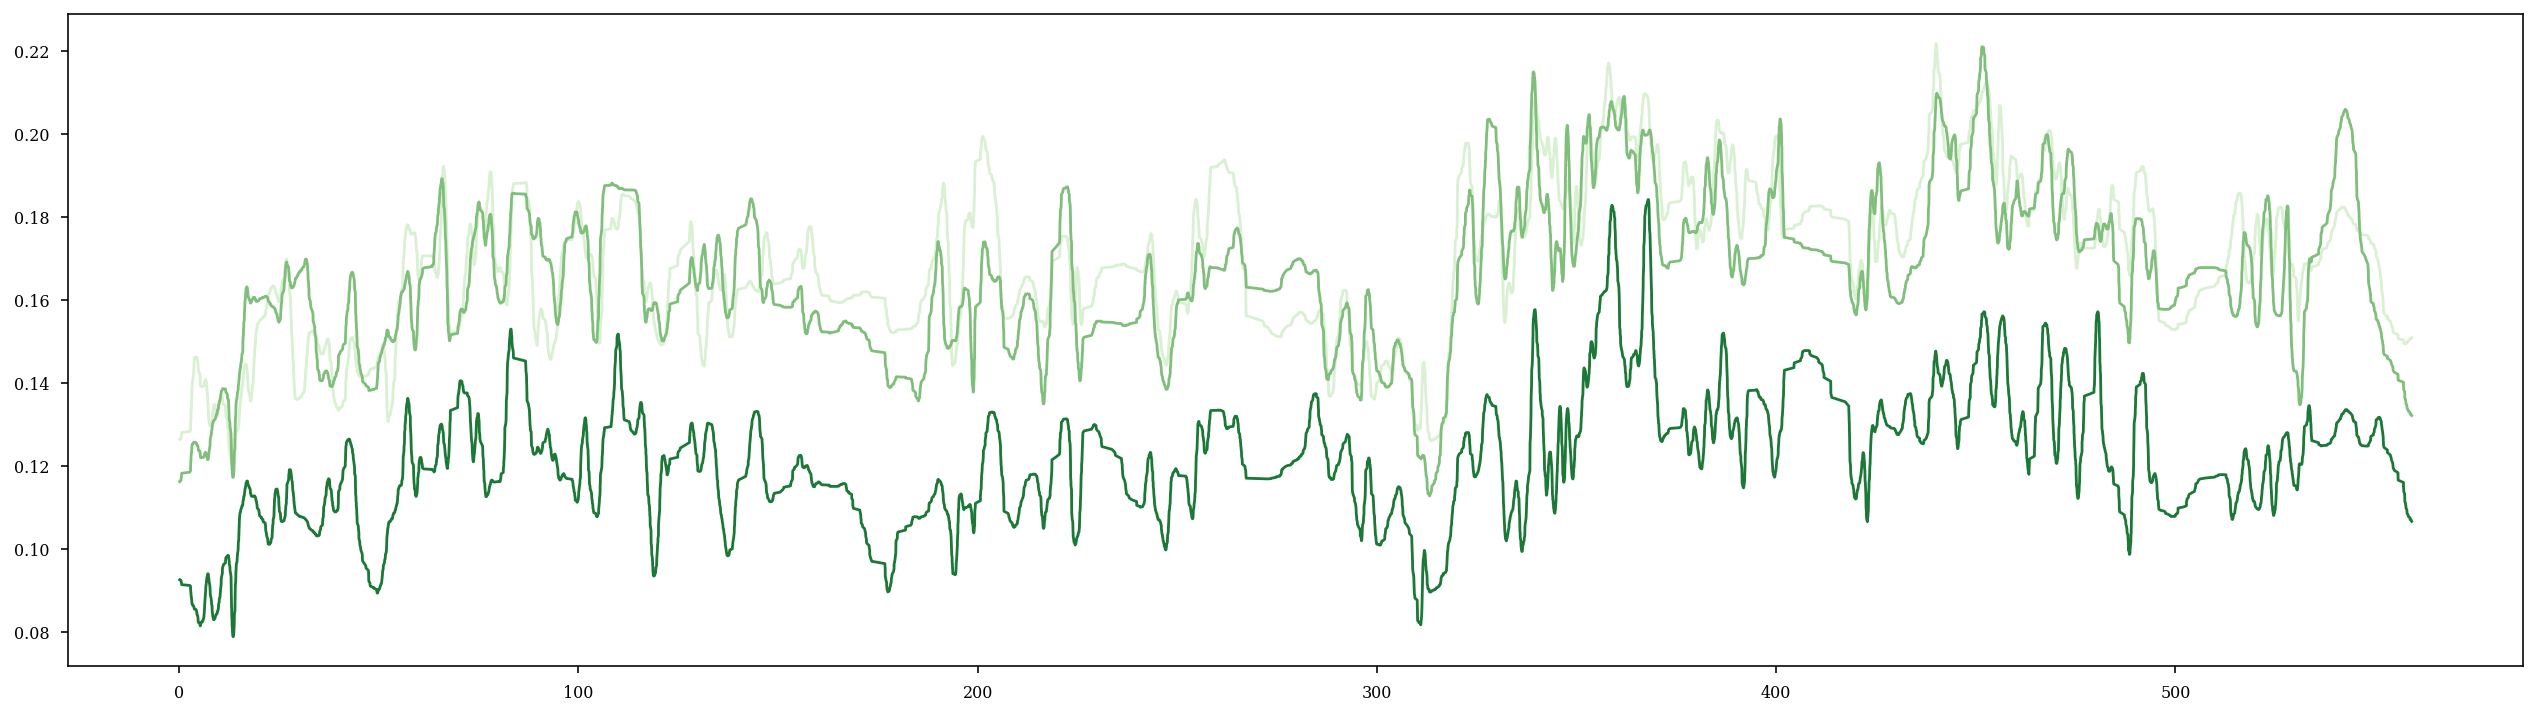

In [43]:
x = np.array(n_sup)
x = x.reshape(int(x.shape[0]/3),3)
x = x/sum(cell_metrics.deepSuperficial== "Superficial")
# plt.plot(x[:,1])

plt.figure(figsize=(22,6))
plt.plot(ripples.peaks/60,gaussian_filter1d(x[:,0], 20),color='#d9f0d3',label="sup start")
plt.plot(ripples.peaks/60,gaussian_filter1d(x[:,1], 20),color='#7fbf7b',label="sup middle")
plt.plot(ripples.peaks/60,gaussian_filter1d(x[:,2], 20),color='#1b7837',label="sup end")
plt.show()


In [168]:
import warnings
warnings.filterwarnings("ignore")
# parallel processing
import multiprocessing
from joblib import Parallel, delayed

def main_loop(rip_i,ripple_epochs,st_rip,cell_metrics,n_deep,n_sup,n_deep_whole_rip,n_sup_whole_rip):

    active = [unit.shape[0]>0 for unit in st_rip[rip_i].data]
    n_deep_whole_rip.append(sum(cell_metrics.deepSuperficial[active] == "Deep"))
    n_sup_whole_rip.append(sum(cell_metrics.deepSuperficial[active] == "Superficial"))

    ts = np.linspace(ripple_epochs[rip_i].starts,ripple_epochs[rip_i].stops,4)
    within_ripple_epochs = nel.EpochArray(np.array([[ts[0],ts[1]],[ts[1],ts[2]],[ts[2],ts[3]]]))
    for rip_inter in range(3):
        active = [unit.shape[0]>0 for unit in st_rip[rip_i][within_ripple_epochs][rip_inter].data]
        n_deep.append(sum(cell_metrics.deepSuperficial[active] == "Deep"))
        n_sup.append(sum(cell_metrics.deepSuperficial[active] == "Superficial"))

    return n_deep,n_sup,n_deep_whole_rip,n_sup_whole_rip

n_deep = []
n_sup = []
n_deep_whole_rip = []
n_sup_whole_rip = []

parallel = 1

# if parallel==1:
num_cores = multiprocessing.cpu_count()  
results = Parallel(n_jobs=num_cores)(delayed(main_loop)(rip_i,
                                                            ripple_epochs,
                                                            st_rip,
                                                            cell_metrics,
                                                            n_deep,
                                                            n_sup,
                                                            n_deep_whole_rip,
                                                            n_sup_whole_rip) for rip_i in tqdm(range(20)))
n_deep,n_sup,n_deep_whole_rip,n_sup_whole_rip
# else:
#     for session in sessions:
#         sys.stdout.write('\rcurrent cell: %s' %(session))
#         sys.stdout.flush()
#         print(session)
#         main_loop(session,data_path,save_path)

# normalize by n units
# n_deep = n_deep/sum(cell_metrics.deepSuperficial == "Deep")
# n_sup = n_sup/sum(cell_metrics.deepSuperficial == "Superficial")
# n_deep_whole_rip = n_deep_whole_rip/sum(cell_metrics.deepSuperficial == "Deep")
# n_sup_whole_rip = n_sup_whole_rip/sum(cell_metrics.deepSuperficial == "Superficial")


100%|██████████| 20/20 [00:00<00:00, 6686.81it/s]


([], [], [], [])

In [186]:
n_deep = np.zeros([3,ripple_epochs.n_intervals])
n_sup = np.zeros_like(n_deep)
n_deep_whole_rip = np.zeros([1,ripple_epochs.n_intervals])
n_sup_whole_rip = np.zeros_like(n_deep_whole_rip)

for i,rip_1 in enumerate(results):
    n_deep[:,i],n_sup[:,i],n_deep_whole_rip[0,i],n_sup_whole_rip[0,i] = rip_1

ValueError: setting an array element with a sequence.

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-

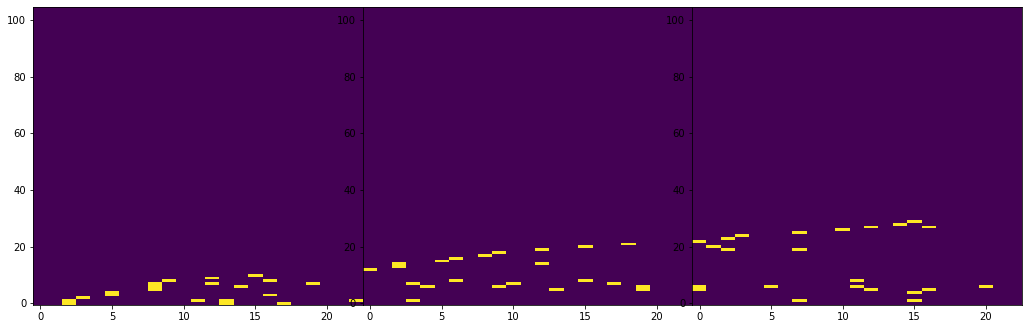

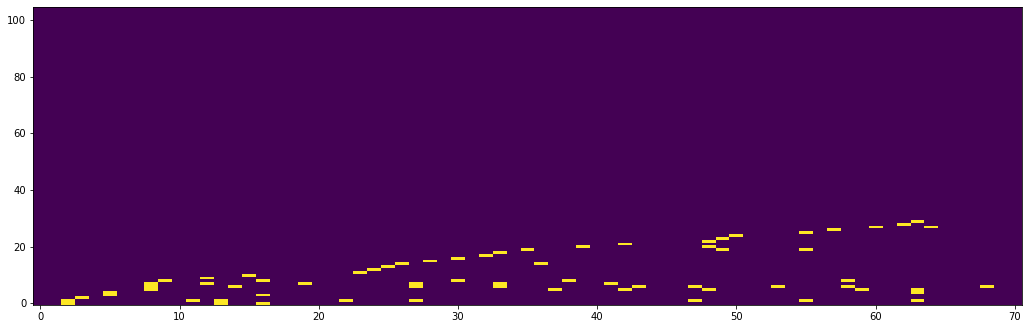

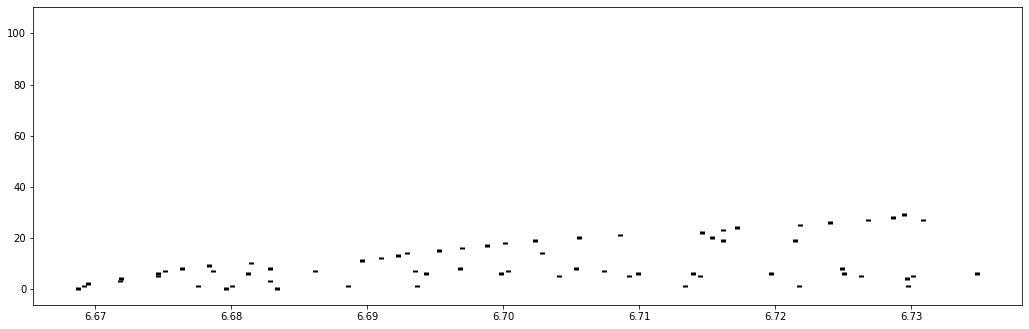

In [107]:
fr_order = np.array(st_rip[0].get_event_firing_order()) - 1

fig, axs = plt.subplots(1,3,figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0)
axs = axs.ravel()

binnedst = st_rip[0][within_ripple_epochs][0].bin(ds=0.001)
axs[0].imshow(binnedst.data[fr_order,:],interpolation="nearest",aspect="auto",origin="lower")

# plt.figure()
binnedst = st_rip[0][within_ripple_epochs][1].bin(ds=0.001)
axs[1].imshow(binnedst.data[fr_order,:],interpolation="nearest",aspect="auto",origin="lower")

binnedst = st_rip[0][within_ripple_epochs][2].bin(ds=0.001)
axs[2].imshow(binnedst.data[fr_order,:],interpolation="nearest",aspect="auto",origin="lower")


plt.figure(figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)))
binnedst = st_rip[0].bin(ds=0.001)
plt.imshow(binnedst.data[fr_order,:],interpolation="nearest",aspect="auto",origin="lower")

plt.figure(figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)))
plt.eventplot(st_rip[0].data[fr_order],color="k",linewidths=5)
plt.show()
